In [1]:
#INSTALLING DEPENDENCIES
!pip install torch==1.12.1
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━

In [2]:
#IMPORT LIBRARIES
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#DATA LOADER:
horizontal_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5)])
batch_size=10000
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=horizontal_flip_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=horizontal_flip_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#UNPICKLING FILES INTO DICTIONARIES:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
dict1 = unpickle(file='./data/cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='./data/cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='./data/cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='./data/cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='./data/cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='./data/cifar-10-batches-py/test_batch')

#LOADING TRAIN AND TEST DATA
train_x1 = torch.tensor(dict1[b'data'])
train_y1 = torch.tensor(dict1[b'labels'])
train_x2 = torch.tensor(dict2[b'data'])
train_y2 = torch.tensor(dict2[b'labels'])
train_x3 = torch.tensor(dict3[b'data'])
train_y3 = torch.tensor(dict3[b'labels'])
train_x4 = torch.tensor(dict4[b'data'])
train_y4 = torch.tensor(dict4[b'labels'])
train_x5 = torch.tensor(dict5[b'data'])
train_y5 = torch.tensor(dict5[b'labels'])
test_x = torch.tensor(dict_test[b'data'])
test_y = torch.tensor(dict_test[b'labels'])

train_x = torch.cat((train_x1, train_x2, train_x3, train_x4, train_x5), dim=0)
train_y = torch.cat((train_y1, train_y2, train_y3, train_y4, train_y5), dim=0)
train_x = torch.reshape(train_x, (50000, 3, 32, 32))/255
test_x = torch.reshape(test_x, (10000, 3, 32, 32))/255

train_y_framed = torch.nn.functional.one_hot(train_y.clone().detach(), num_classes=10)
train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
test_y_framed = torch.nn.functional.one_hot(test_y.clone().detach(), num_classes=10)
test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-3-923f3ca44ac2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
<ipython-input-3-923f3ca44ac2>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


In [4]:
#DEFINING MODEL:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con1 = torch.nn.Conv2d(3,32,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con2 = torch.nn.Conv2d(32,64,(5,5),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con3 = torch.nn.Conv2d(64,64,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.pool = torch.nn.MaxPool2d((2,2), stride=(2,2), padding=0)
        self.f1 = torch.nn.Linear(64*7*7, 64)
        self.f2 = torch.nn.Linear(64, 10)
        self.soft_max = torch.nn.LogSoftmax(dim=1)
        self.rel = torch.nn.functional.relu

    def forward(self, x):
        x = self.con1(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con2(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con3(x)
        x = self.rel(x)
        x = torch.reshape(x, (-1, 64*7*7))
        x = self.f1(x)
        x = self.rel(x)
        x = self.f2(x)
        predict = self.soft_max(x)
        return predict

#PARAMETERS:
epochs = 10
batch = 32
n_batches = 1562

In [6]:
#RUNNING THE MODEL ON TRAINING AND TESTING:

mymodel = Model().to('cuda:0')
criterion = nn.CrossEntropyLoss()
# kl_criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
val_loss = torch.empty(epochs)
train_loss = torch.empty(epochs)
valb = 32
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_t = np.zeros(epochs)
acc_v = np.zeros(epochs)
for epoch in range(epochs):
  rloss = 0
  acc = 0
  count = 0
  vloss = 0
  for b in range(n_batches):
  # for b in range(10):
    xbatch = train_x[(b)*batch:(b+1)*(batch)].to('cuda:0')
    ybatch = train_y_framed[(b)*batch:(b+1)*(batch)].to('cuda:0')
    predict = mymodel.forward(xbatch)
    loss = criterion(predict,ybatch)
    optimizer.zero_grad()
    loss.backward()
    rloss+=loss.item()
    optimizer.step()
  predict_val = mymodel.forward(test_x[:1000].to('cuda:0'))
  loss2 = criterion(predict_val, test_y_framed[:1000].to('cuda:0')).item()
  print(f"Training Loss after epoch {epoch+1}: {rloss}")
  train_loss[epoch] = rloss
  val_loss[epoch] = loss2
  predict_val_v = mymodel.forward(test_x[:1000].to('cuda:0'))
  predict_val_t = mymodel.forward(train_x[:1000].to('cuda:0'))
  pred_labels_v = torch.argmax(predict_val_v, dim=1)
  pred_labels_t = torch.argmax(predict_val_t, dim=1)
  acc_t[epoch]= metric(pred_labels_t, train_y[:1000].to('cuda:0'))
  acc_v[epoch]=metric(pred_labels_v, test_y[:1000].to('cuda:0'))
  print(f'TRAIN_ACC: {acc_t[epoch]}')
  print(f'VAL ACC: {acc_v[epoch]}')
  ## Validation loss 
  print(f"Validation Loss after epoch {epoch+1}: {loss2}")
  # p1 = torch.argmax(predic,dim=1)
  # p2 = torch.argmax(test_y_framed[:500], dim=1)
  # count = torch.sum(p2)
  # val_accs[epoch] = torch.sum(torch.where(p1==p2,1,0))/count
  # print(f'Validation acc after epoch {epoch+1}: {val_accs[epoch]}')
print(acc_t)
print(acc_v)


Training Loss after epoch 1: 18183.34552755952
TRAIN_ACC: 0.5720000267028809
VAL ACC: 0.574999988079071
Validation Loss after epoch 1: 1.184314250946045
Training Loss after epoch 2: 13857.237667200156
TRAIN_ACC: 0.6610000133514404
VAL ACC: 0.6399999856948853
Validation Loss after epoch 2: 1.0387996435165405
Training Loss after epoch 3: 12136.676600636914
TRAIN_ACC: 0.6809999942779541
VAL ACC: 0.6389999985694885
Validation Loss after epoch 3: 1.0611460208892822
Training Loss after epoch 4: 10961.354555872269
TRAIN_ACC: 0.6690000295639038
VAL ACC: 0.6370000243186951
Validation Loss after epoch 4: 1.1589186191558838
Training Loss after epoch 5: 10049.446280814707
TRAIN_ACC: 0.6809999942779541
VAL ACC: 0.6480000019073486
Validation Loss after epoch 5: 1.1613104343414307
Training Loss after epoch 6: 9397.906729346258
TRAIN_ACC: 0.6970000267028809
VAL ACC: 0.628000020980835
Validation Loss after epoch 6: 1.2692586183547974
Training Loss after epoch 7: 8782.498799790861
TRAIN_ACC: 0.722000002

In [7]:
#CALCULATING FINAL VALIDATION ACCURACY AND CLASSWISE ACCURACIES:
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_metric = MulticlassAccuracy(num_classes=10, average=None).to('cuda:0')
# finalpred = mymodel.forward(test_x[:1000])
pred_labels = torch.argmax(predict_val_v, dim=1)
classaccs = acc_metric(pred_labels, test_y[:1000].to('cuda:0'))
accfinal = metric(pred_labels, test_y[:1000].to('cuda:0'))
print(accfinal)
print(classaccs)
# class_acc[0]=classaccs

tensor(0.6460, device='cuda:0')
tensor([0.6796, 0.7528, 0.3900, 0.5340, 0.5000, 0.3953, 0.6161, 0.8039, 0.8774,
        0.8440], device='cuda:0')


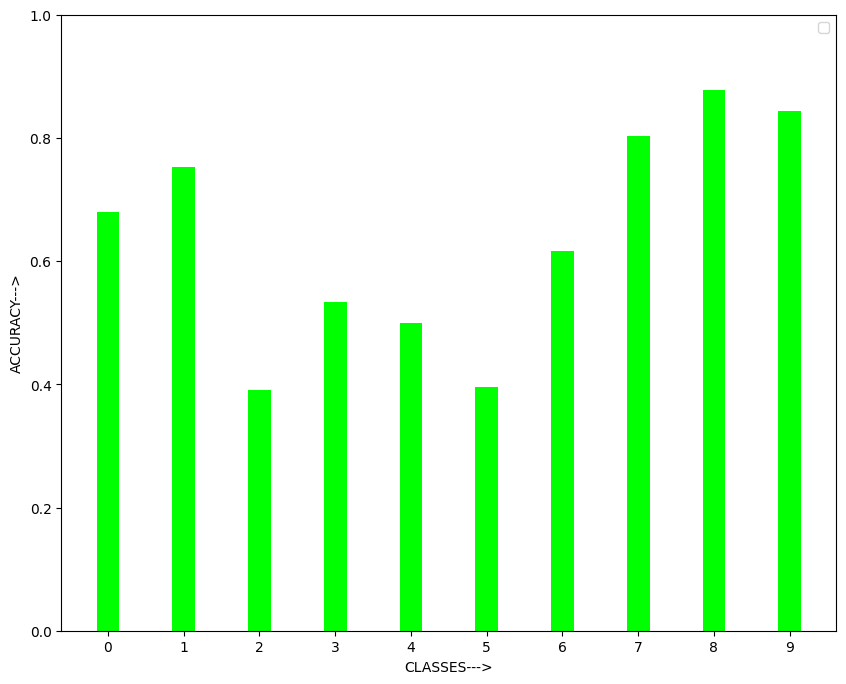

In [9]:
#CLASSWISE ACCURACY BAR-GRAPH
plt.figure(figsize=(10,8))
plt.xlabel('CLASSES--->')
plt.ylabel('ACCURACY--->')
plt.xticks(np.arange(0,10))
plt.ylim(0,1)
plt.bar(np.arange(0,10),classaccs.to('cpu'),color='lime',width=0.3)
plt.legend()
plt.show()

In [10]:
#PRINTING THE LOSSES:
print(train_loss)
print(val_loss)
train_loss = train_loss/499.84
val_loss = val_loss/10
print(train_loss)
print(val_loss)
tloss = train_loss.detach().numpy()
vloss = val_loss.detach().numpy()

tensor([18183.3457, 13857.2373, 12136.6768, 10961.3545, 10049.4463,  9397.9062,
         8782.4990,  8322.7666,  7929.7822,  7438.0356])
tensor([1.1843, 1.0388, 1.0611, 1.1589, 1.1613, 1.2693, 1.3048, 1.3328, 1.3143,
        1.4121])
tensor([36.3783, 27.7233, 24.2811, 21.9297, 20.1053, 18.8018, 17.5706, 16.6509,
        15.8646, 14.8808])
tensor([0.1184, 0.1039, 0.1061, 0.1159, 0.1161, 0.1269, 0.1305, 0.1333, 0.1314,
        0.1412])


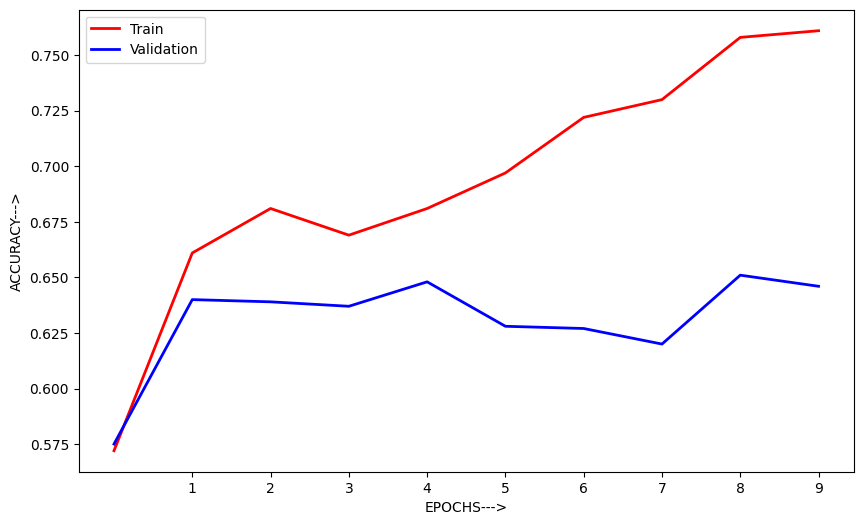

In [11]:
#CODE TO PLOT VALIDATION ACCURACY:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,10)
epoch_ticks = np.arange(1,11)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, acc_t, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, acc_v, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

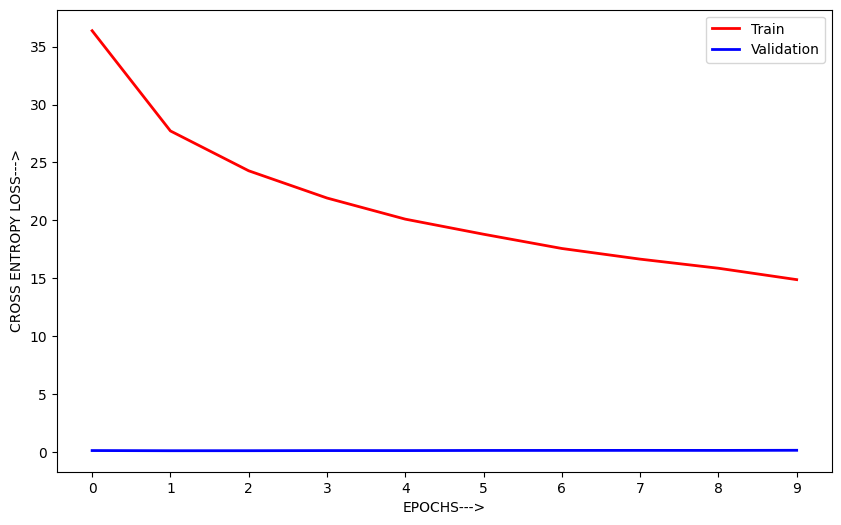

In [12]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,10)
epoch_ticks = np.arange(0,11)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

In [13]:
# Batch size = 32:
v32 = [0.5605, 0.6355, 0.6760, 0.6795, 0.6850, 0.6825, 0.6800, 0.6700, 0.6680,
        0.6690, 0.6700, 0.6655, 0.6445, 0.6510, 0.6570, 0.6515, 0.6375, 0.6415,
        0.6470, 0.6480, 0.6455, 0.6385, 0.6500, 0.6575, 0.6320, 0.6475, 0.6440,
        0.6425, 0.6565, 0.6580, 0.6430, 0.6510, 0.6580, 0.6490, 0.6515]

# Batch size = 16:
v16 = [0.5680, 0.6380, 0.6695, 0.6785, 0.6725, 0.6770, 0.6685, 0.6660, 0.6575,
        0.6425, 0.6505, 0.6540, 0.6610, 0.6465, 0.6450, 0.6455, 0.6515, 0.6375,
        0.6405, 0.6400]

# Batch size = 8:
v8 = [0.5725, 0.6320, 0.6545, 0.6595, 0.6515, 0.6585, 0.6580, 0.6390, 0.6435,
        0.6435, 0.6335, 0.6260, 0.6190, 0.6180, 0.6225, 0.6300, 0.6295, 0.6290,
        0.6175, 0.6105]

# Batch size = 4:
v4 = [0.5735, 0.6265, 0.6370, 0.6555, 0.6605, 0.6430, 0.6220, 0.6250, 0.6395,
        0.6360, 0.6530, 0.6400, 0.6395, 0.6445, 0.6440, 0.6300, 0.6300, 0.6245,
        0.6330, 0.6375]

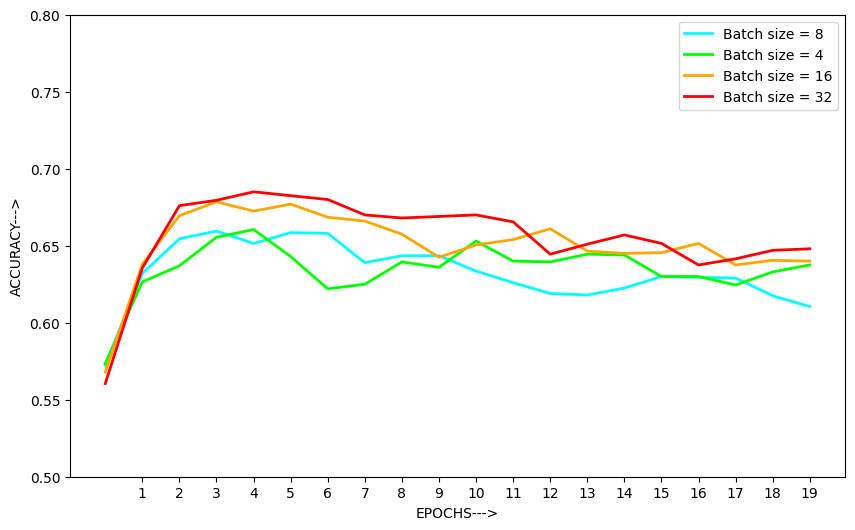

In [14]:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(1,21)
plt.xticks(epoch_ticks)
plt.ylim(0.5,0.8)
plt.plot(epoch_arr, v8, 'cyan', label='Batch size = 8', linewidth=2)
plt.plot(epoch_arr, v4, 'lime', label='Batch size = 4', linewidth=2)
plt.plot(epoch_arr, v16, 'orange', label='Batch size = 16', linewidth=2)
plt.plot(epoch_arr, v32[:20], 'red', label='Batch size = 32', linewidth=2)

plt.legend()
plt.show()

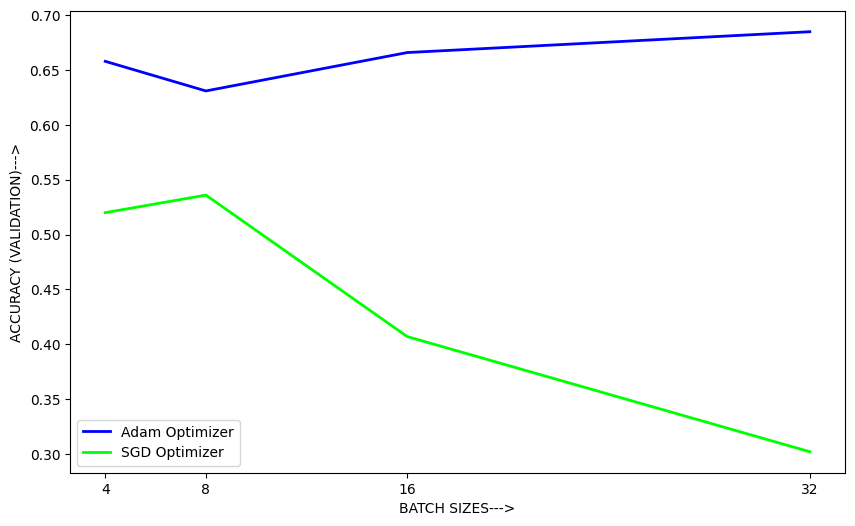

In [15]:
#ACCURACY ON VAL VS BATCH SIZE:
accs_b = [0.6580, 0.6310, 0.6660, 0.6850]
accs_sgd = [0.52, 0.5360, 0.4070, 0.3020]
batchsizes = [4,8,16,32]
plt.figure(figsize=(10,6))
plt.xlabel('BATCH SIZES--->')
plt.ylabel('ACCURACY (VALIDATION)--->')
plt.xticks(batchsizes)
# plt.ylim(90,93)
plt.plot(batchsizes, accs_b, 'blue',label='Adam Optimizer', linewidth=2)
plt.plot(batchsizes, accs_sgd, 'lime',label='SGD Optimizer', linewidth=2)
plt.legend()
plt.show()